# Data Collection, Cleaning, and Exploratory Data Analysis

For the pilot version, we gathered the information for 52 companies in the Utilities and Energy industry. We collected data from three different sources:

1) Wharton Research Data Services (WRDS)
2) Yahoo Finance 
3) Bloomberg terminal

In this notebook, we will present the collection process for each one of the sources, data cleaning, merging, and exploratory data analysis. 

Let's get started!

First, let's import some necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

## WRDS

We assessed the Compustat North America database through the Wharton research data services site. This database has fundamental and market information on active and inactive publicly held companies in the US and Canada. 

We focused on the Fundamentals Annual information and selected the following parameters to collect the data:

1) Data range - From January 2005 to February 2020
2) TIC - Submitted the 52 tickers from the initial companies
3) Screening variables - Industrial format

We selected the following columns:
1) Company Name
2) Ticker Symbol
3) CUSIP - Another company identifier
4) CIK Number - Identifier by the SEC
5) AT - Assets - Total
6) Sales/Turnover (Net)
7) Net Income (Loss)

We exported this information to a csv and now we are going to explore it.

In [2]:
stocks = pd.read_csv("/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/wrds_52_data.csv")
print(f'The WRDS dataset has {stocks.shape[0]} rows and {stocks.shape[1]} columns')
stocks.head(3)

The WRDS dataset has 782 rows and 10 columns


,gvkey,datadate,fyear,tic,cusip,conm,at,ni,sale,cik
0,1075,20051231,2005,PNW,723484101,PINNACLE WEST CAPITAL CORP,11322.645,176.267,2987.955,764622
1,1075,20061231,2006,PNW,723484101,PINNACLE WEST CAPITAL CORP,11455.943,327.255,3401.748,764622
2,1075,20071231,2007,PNW,723484101,PINNACLE WEST CAPITAL CORP,11243.712,307.143,3523.620,764622


In [3]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     782 non-null    int64  
 1   datadate  782 non-null    int64  
 2   fyear     782 non-null    int64  
 3   tic       782 non-null    object 
 4   cusip     782 non-null    object 
 5   conm      782 non-null    object 
 6   at        779 non-null    float64
 7   ni        779 non-null    float64
 8   sale      779 non-null    float64
 9   cik       782 non-null    int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 61.2+ KB


Columns Data types in the dataset:

- 4 integers
- 3 Object (Category) (String) 
- 3 floats

Also, there are three columns with missing values (Total Assets, Net Income, and Total Sales).

In [4]:
print(f'We have {stocks.duplicated().sum()} duplicated rows')
print(f'Number of companies: {len(stocks.tic.unique())}')

We have 0 duplicated rows
Number of companies: 52


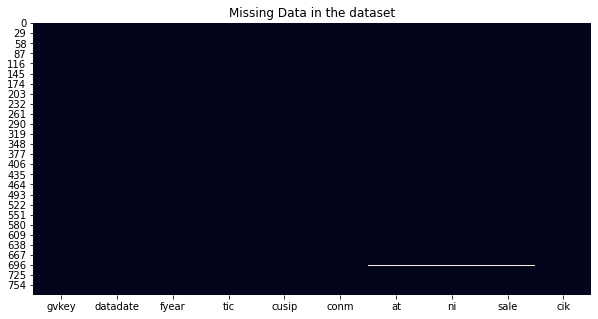

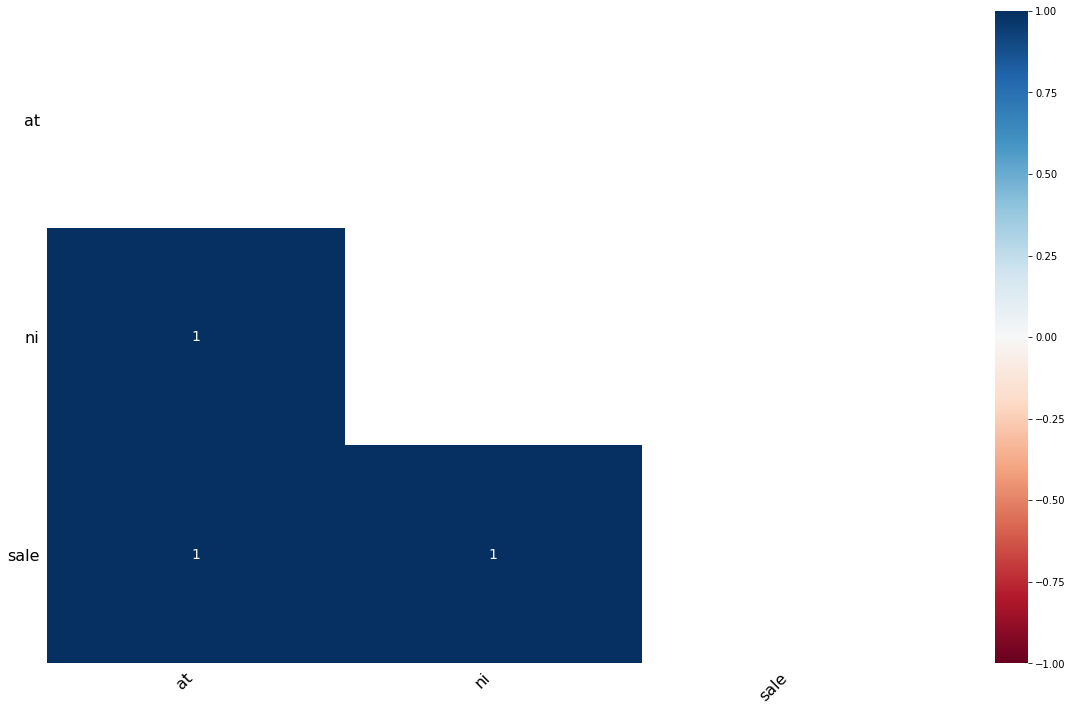

In [5]:
plt.figure(figsize=(10,5));
sns.heatmap(stocks.isnull(), cbar=False).set(title='Missing Data in the dataset');
msno.heatmap(stocks);

As presented previously, we can see null values in the Total Asset, Net Income and Sale columns

In [6]:
stocks[(stocks['at'].isna()) | (stocks['ni'].isna()) | (stocks['sale'].isna())]

,gvkey,datadate,fyear,tic,cusip,conm,at,ni,sale,cik
697,32106,20141231,2014,BKR,05722G100,BAKER HUGHES CO,NaN,NaN,NaN,1701605
698,32106,20151231,2015,BKR,05722G100,BAKER HUGHES CO,NaN,NaN,NaN,1701605
699,32106,20161231,2016,BKR,05722G100,BAKER HUGHES CO,NaN,NaN,NaN,1701605


We are only three rows are missing these values. All of them, correspond to the same company: BKR - Baker Hughes.

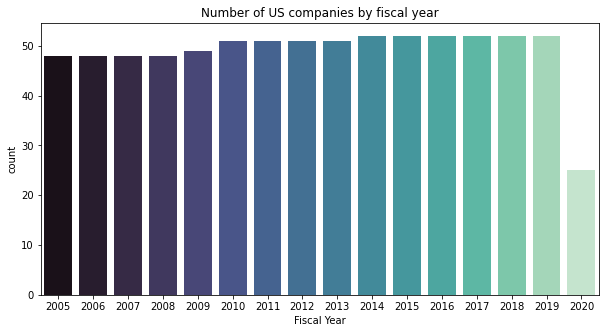

In [7]:
company_byyear = stocks.groupby(by='fyear')['tic'].count()
plt.figure(figsize=(10,5));
plt.title('Number of US companies by fiscal year');
sns.countplot(x='fyear', data=stocks, palette='mako');
plt.xlabel('Fiscal Year');

As the visualization presents, we don't have that much 2020 data. It could be possible that at the moment we gathered the information, WRDS was still gathering data from last year. 

After this finding, we decided to exclude financial information from 2020. In the next step, we drop the observations from 2020.

In [8]:
stocks = stocks.loc[stocks.fyear != 2020, ]
print(f'Now, the WRDS dataset has {stocks.shape[0]} rows and {stocks.shape[1]} columns')

Now, the WRDS dataset has 757 rows and 10 columns


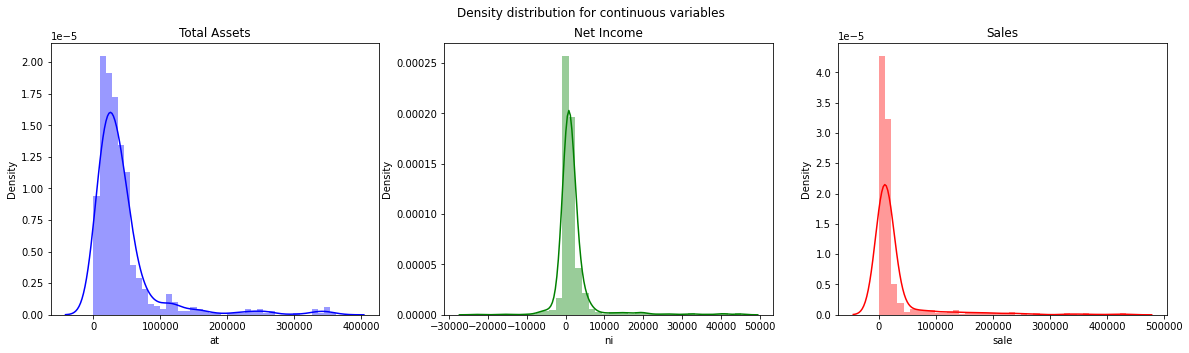

In [9]:
fig, axs = plt.subplots(1,3, figsize=(20,5));
fig.suptitle('Density distribution for continuous variables');
sns.distplot(stocks['at'], ax=axs[0], color='b', bins = 40);
axs[0].set_title('Total Assets');
sns.distplot(stocks.ni, ax=axs[1], color='g', bins = 40);
axs[1].set_title('Net Income');
sns.distplot(stocks.sale, ax=axs[2], color='r', bins = 40);
axs[2].set_title('Sales');

The majority of the companies have total assets of around 500,000 dollars, a net income of around 5,000 dollars, and total sales from 0 to 500,000 dollars.

As the graph in the middle presents, we have companies operating in a net loss. 

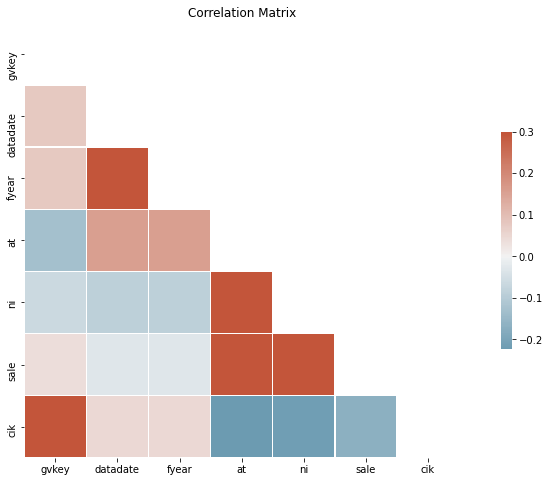

In [10]:
corr = stocks.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 8))
fig.suptitle('Correlation matrix')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Correlation Matrix');

As expected, Total Assets, Total Sales, and Net Income are highly correlated. However, these values are going to be useful to calculate the growth ratios. Hopefully, 
these ratios provide us more insights.


### Calculating Growth Ratios

- % Change in Sales = ((Sales in Current Year) / (Sales Last Year) - 1) * 100
- % Change in Assets = ((Assets in Current Year) / (Assets Last Year) - 1) * 100
- % Change in Net Income = ((Net Income in Current Year) / (Net Income Last Year) - 1) * 100


We want to know how total sales, assets, and net income changed throughout the years. This could give more insights than comparing the value only. 

In [11]:
company = list(stocks['conm'].unique())

def calculate_growth_ratios(company):
    for com in company:
        a =  stocks.loc[stocks.conm == com, ['fyear','at','ni','sale']]
        l = len(a)
        count = 0
        at2 = []
        ni = []
        sale = []
        while count < l:
            index = count - 1
            if(count != 0):
                #assets ratio
                current_a = a.iloc[count,1]
                last_a = a.iloc[index,1]
                at = ((current_a)/(last_a)-1)*100
                at2.append(at)
                ##net income ratio
                current_ni = a.iloc[count,2]
                last_ni = a.iloc[index,2]
                ni_1 = ((current_ni)/(last_ni)-1)*100
                ni.append(ni_1)
                #Sales ratio
                current_s = a.iloc[count,3]
                last_s = a.iloc[index,3]
                sales = ((current_s)/(last_s)-1)*100
                sale.append(sales)
            else:
                at2.append(0)
                ni.append(0)
                sale.append(0)
            count += 1

        stocks.loc[stocks.conm == com, 'Change_in_Sales'] = sale
        stocks.loc[stocks.conm == com,'Change_in_Assets'] = at2
        stocks.loc[stocks.conm == com, 'Change_in_NI'] = ni

In [12]:
calculate_growth_ratios(company)
stocks.head(3)

,gvkey,datadate,fyear,tic,cusip,conm,at,ni,sale,cik,Change_in_Sales,Change_in_Assets,Change_in_NI
0,1075,20051231,2005,PNW,723484101,PINNACLE WEST CAPITAL CORP,11322.645,176.267,2987.955,764622,0.000000,0.000000,0.000000
1,1075,20061231,2006,PNW,723484101,PINNACLE WEST CAPITAL CORP,11455.943,327.255,3401.748,764622,13.848703,1.177269,85.658688
2,1075,20071231,2007,PNW,723484101,PINNACLE WEST CAPITAL CORP,11243.712,307.143,3523.620,764622,3.582629,-1.852584,-6.145666


In 2005, we don't see any changes because we don't have 2004 data. This will happen to the first-year observation of each company.

For 2006, we can see an 86% increase in Net income, 13.85% in Sales, and 1.18% in Assets. However, for 2007, there is a decrease in Assets and Net Income.

### Financial Ratios

- Return on Assets (ROA) = (Net Income in Current Year / Total Assets in Current Year) * 100
- Profit Margin = (Net Income in Current Year / Total Sales in Current Year) * 100

In [13]:
stocks['ROA'] = (stocks.ni/stocks['at']) * 100
stocks['Profit_Margin'] = (stocks.ni/stocks.sale) * 100
stocks.tail(3)

,gvkey,datadate,fyear,tic,cusip,conm,at,ni,sale,cik,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin
779,186989,20171231,2017,MPC,56585A102,MARATHON PETROLEUM CORP,49047.0,3432.0,66974.0,1510295,19.954149,10.433882,192.333901,6.997370,5.124377
780,186989,20181231,2018,MPC,56585A102,MARATHON PETROLEUM CORP,92940.0,2780.0,96504.0,1510295,44.091737,89.491712,-18.997669,2.991177,2.880710
781,186989,20191231,2019,MPC,56585A102,MARATHON PETROLEUM CORP,98556.0,2637.0,123949.0,1510295,28.439236,6.042608,-5.143885,2.675636,2.127488


## Yahoo Finance

Now, we are going to collect more financial information using the Yahoo Finance API. We are going to send the following parameters to the API:

1) 52 Tickers 
2) Period - 10 years
3) Interval - 1 month (Every month for the past 10 years)

Later on, we would need to transform this dataset from monthly to yearly so we are able to merge it with the WRDS dataset

In [14]:
!pip install yfinance
import yfinance as yf

In [15]:
tickers = pd.read_csv("/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/SP500_52tickers.txt",delimiter = "\t", header=None)
tickers.columns = ['TickerId']
print(f'The number of tickers - {len(tickers.TickerId.unique())} that we are going to download')

The number of tickers - 52 that we are going to download


In [16]:
tickers_list = tickers['TickerId'].to_list()
tickers_to_run = ''
for ticker in tickers_list:
    tickers_to_run += ticker + " "
tickers_to_run

df_yahoo = yf.download(tickers_to_run, period="10y", interval="1mo", group_by = 'ticker')

[*********************100%***********************]  52 of 52 completed


In [17]:
yahoo = pd.DataFrame()
for ticker in tickers_list:
    td = df_yahoo[ticker]
    td['Ticker'] = ticker
    yahoo = yahoo.append(td)
yahoo.reset_index(inplace=True)
yahoo['Year'] = pd.DatetimeIndex(yahoo.Date).year
print(f'We have {yahoo.duplicated().sum()} duplicated rows')
print(f'The Yahoo dataset has {yahoo.shape[0]} rows and {yahoo.shape[1]} columns')
yahoo.head(3)

We have 0 duplicated rows
The Yahoo dataset has 27820 rows and 9 columns


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year
0,2011-07-13,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
1,2011-07-20,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
2,2011-07-21,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011


In [18]:
yahoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27820 non-null  datetime64[ns]
 1   Open       6268 non-null   float64       
 2   High       6268 non-null   float64       
 3   Low        6268 non-null   float64       
 4   Close      6268 non-null   float64       
 5   Adj Close  6268 non-null   float64       
 6   Volume     6268 non-null   float64       
 7   Ticker     27820 non-null  object        
 8   Year       27820 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.9+ MB


We created a Year column to be able to merge this file with WRDS and visualization purposes. 

Columns Data types in the dataset:

- 1 Object (Category) (String) 
- 6 floats

Also, we are missing 2,840 rows for each column collected from Yahoo. We are going to see this in more detail.

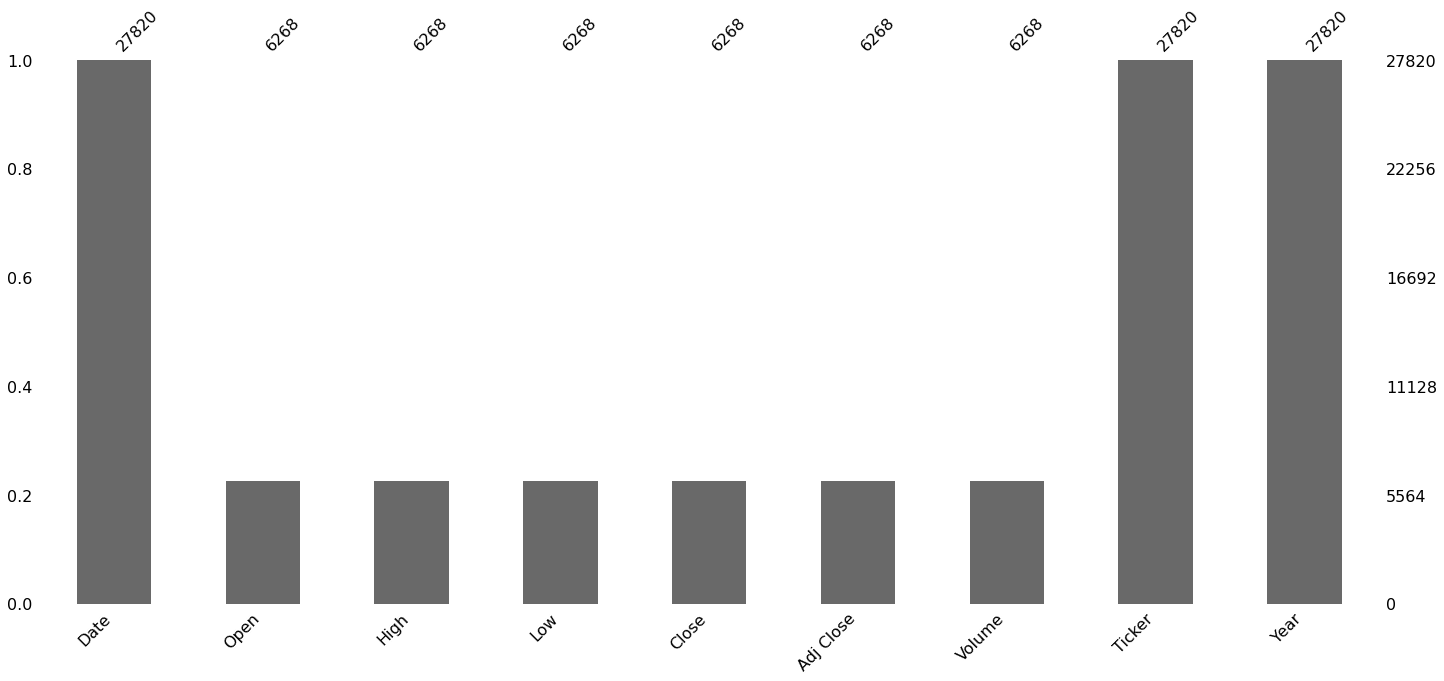

In [19]:
plt.figure(figsize=(10,5));
msno.bar(yahoo);

In [20]:
yahoo.loc[(yahoo.Year == 2020), ].count()

Date         2548
Open          624
High          624
Low           624
Close         624
Adj Close     624
Volume        624
Ticker       2548
Year         2548
dtype: int64

Similar to WRDS, we are missing data for 2020. We decided to drop these observations and just consider data from 2005 to 2019 for the pilot predictive model.

In [21]:
yahoo = yahoo.loc[yahoo.Year < 2020, ]
print(f'Now, we have {yahoo.shape[0]} rows.')

Now, we have 23712 rows.


In [22]:
yahoo.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5228.0,5.447951e+01,2.916711e+01,7.988212e+00,3.287500e+01,4.879500e+01,7.140250e+01,2.314100e+02
High,5228.0,5.720621e+01,3.062903e+01,8.451866e+00,3.467375e+01,5.129500e+01,7.493500e+01,2.346000e+02
Low,5228.0,5.160885e+01,2.766745e+01,6.520000e+00,3.095750e+01,4.608500e+01,6.792250e+01,2.169300e+02
Close,5228.0,5.467221e+01,2.923531e+01,8.210000e+00,3.295000e+01,4.900750e+01,7.170000e+01,2.298100e+02
Adj Close,5228.0,4.603772e+01,2.696067e+01,6.188948e+00,2.615604e+01,4.024028e+01,6.025032e+01,2.198632e+02
Volume,5228.0,9.203312e+07,7.815895e+07,2.455200e+06,3.933625e+07,7.217660e+07,1.199364e+08,1.509896e+09
Year,23712.0,2.014991e+03,2.527952e+00,2.011000e+03,2.013000e+03,2.015000e+03,2.017000e+03,2.019000e+03


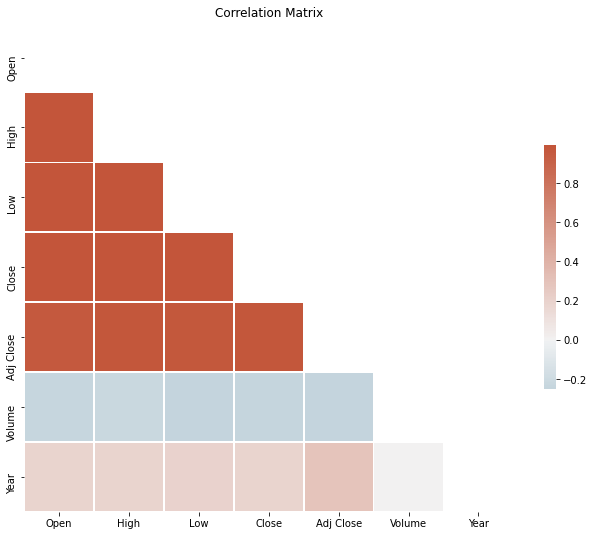

In [23]:
corr  = yahoo.corr()
mask = np.triu(np.ones_like(corr, dtype=bool));
f, ax = plt.subplots(figsize=(11, 9));
cmap = sns.diverging_palette(230, 20, as_cmap=True);
plt.title('Correlation Matrix');
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [24]:
df = yahoo.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Year
0,2011-07-13,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
1,2011-07-20,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
2,2011-07-21,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
3,2011-07-27,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011
4,2011-07-28,NaN,NaN,NaN,NaN,NaN,NaN,AEE,2011


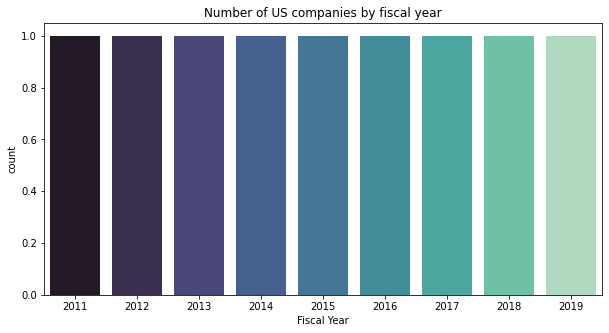

In [26]:
company_byyear = df.groupby(by='Year')['Ticker'].count().reset_index()
plt.figure(figsize=(10,5));
plt.title('Number of US companies by fiscal year');
sns.countplot(x='Year', data=company_byyear, palette='mako');
plt.xlabel('Fiscal Year');

We have observations from 2011 to 2019 and similar number of companies in each year. 

In [27]:
agg = df.loc[df.Year == 2019, ].groupby(['Ticker','Year'])[['Adj Close']].mean().sort_values(by='Adj Close', ascending=False).reset_index()[:5]
agg

,Ticker,Year,Adj Close
0,PXD,2019,135.340789
1,SRE,2019,126.494287
2,AWK,2019,110.768525
3,CVX,2019,107.451714
4,ATO,2019,101.304762


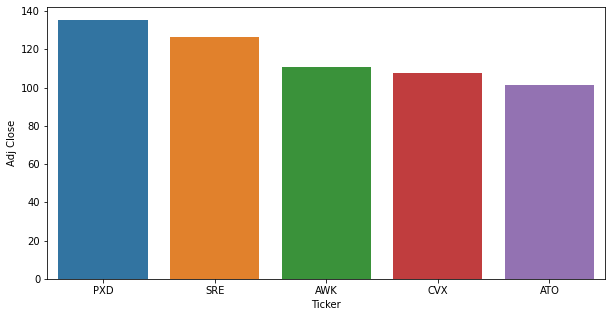

In [28]:
plt.figure(figsize=(10,5));
sns.barplot(x='Ticker',y='Adj Close', data=agg);

The visualization presents the top 5 companies with the highest Average Adjusted Closing price for 2019. Let's remember that the adjusted closing price reflects that stock's value after accounting for any corporate actions. It seems the PXD had a good year, let's see the time series for this specific company. 

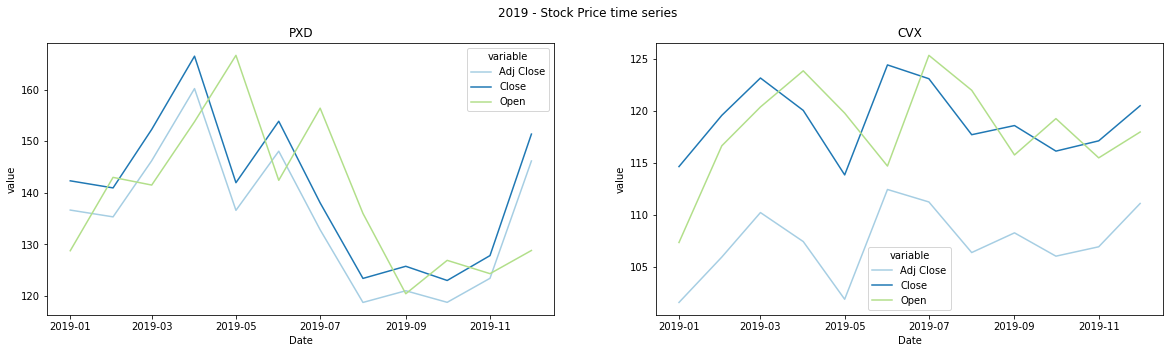

In [29]:
pxd_df = df.loc[(df.Year == 2019) & (df.Ticker =='PXD'), ]
pxd_melt = pd.melt(pxd_df, id_vars=['Date'], value_vars=['Adj Close','Close','Open'])
cvx_df = df.loc[(df.Year == 2019) & (df.Ticker =='CVX'), ]
cvx_df = pd.melt(cvx_df, id_vars=['Date'], value_vars=['Adj Close','Close','Open'])

fig, axs = plt.subplots(1,2, figsize=(20,5));
fig.suptitle('2019 - Stock Price time series');
sns.lineplot(x='Date',y='value', ax=axs[0], hue='variable', data = pxd_melt, palette='Paired');
axs[0].set_title('PXD');
sns.lineplot(x='Date',y='value', ax=axs[1], hue='variable', data = cvx_df, palette='Paired');
axs[1].set_title('CVX');

As expected, PXD stock has higher prices. Also, we can notice PXD Open, Close and Adjusted Close stock prices didn't vary too much throughout the year. However, CVX Adjusted closing price is very different from the Open and Close price. Another interesting point is the stock price decrease around August and September 2019.


We will know to explore the Volume variable. This variable measures the number of stocks shares that are treated on a stock exchange each day. The volume is important because it confirms trend directions. 

In [30]:
df_vol = df.loc[(df.Year <= 2019) & (df.Year >= 2015),].groupby(['Ticker','Year']).mean().sort_values(by=['Ticker','Year', 'Volume'], ascending=False).reset_index()
df_vol

,Ticker,Year,Open,High,Low,Close,Adj Close,Volume
0,XOM,2019,73.365833,76.558334,70.708333,73.309999,64.087932,2.440118e+08
1,XOM,2018,80.738333,84.067500,75.790001,79.453334,66.561400,2.852170e+08
2,XOM,2017,82.165834,84.060000,79.858334,81.560834,65.734543,2.290612e+08
3,XOM,2016,85.030834,88.872501,82.381667,86.416666,67.215259,2.605764e+08
4,XOM,2015,83.481666,85.957499,79.109167,82.323332,61.795919,2.958736e+08
...,...,...,...,...,...,...,...,...
255,AEE,2019,73.735833,76.269166,71.601666,74.755833,70.741501,3.115070e+07
256,AEE,2018,60.576667,62.927500,58.021667,61.096667,56.248278,3.324740e+07
257,AEE,2017,56.704167,58.711667,55.271667,57.242500,51.093671,2.950146e+07
258,AEE,2016,48.831667,50.909167,46.895834,49.639166,42.828545,3.711812e+07


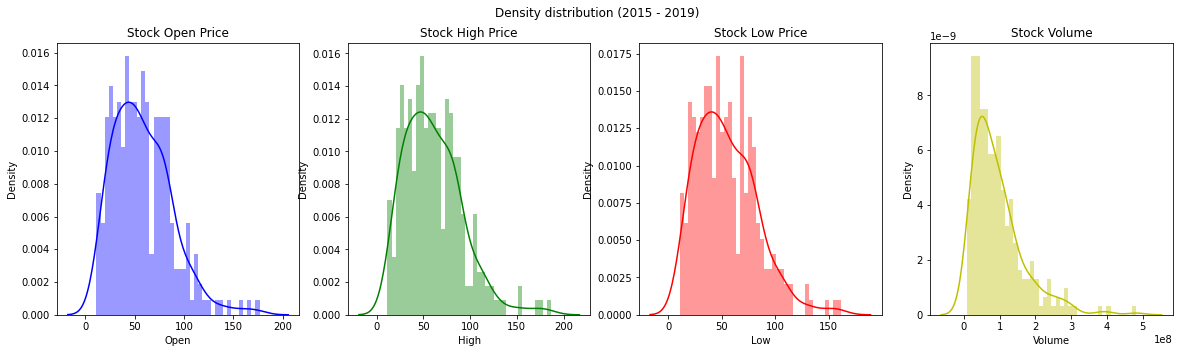

In [31]:
fig, axs = plt.subplots(1,4, figsize=(20,5));
fig.suptitle('Density distribution (2015 - 2019)');
sns.distplot(df_vol.Open, ax=axs[0], color='b', bins = 40);
axs[0].set_title('Stock Open Price');
sns.distplot(df_vol.High, ax=axs[1], color='g', bins = 40);
axs[1].set_title('Stock High Price');
sns.distplot(df_vol.Low, ax=axs[2], color='r', bins = 40);
axs[2].set_title('Stock Low Price');
sns.distplot(df_vol.Volume, ax=axs[3], color='y', bins = 40);
axs[3].set_title('Stock Volume');

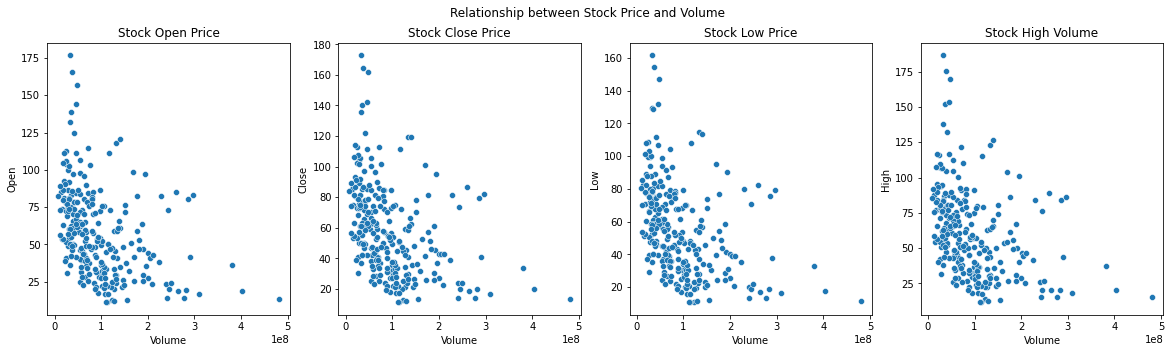

In [32]:
fig, axs = plt.subplots(1,4, figsize=(20,5));
fig.suptitle('Relationship between Stock Price and Volume');
sns.scatterplot(data=df_vol, ax=axs[0], x='Volume',y='Open');
axs[0].set_title('Stock Open Price');
sns.scatterplot(data=df_vol, ax=axs[1], x='Volume',y='Close');
axs[1].set_title('Stock Close Price');
sns.scatterplot(data=df_vol, ax=axs[2], x='Volume',y='Low');
axs[2].set_title('Stock Low Price');
sns.scatterplot(data=df_vol, ax=axs[3], x='Volume',y='High');
axs[3].set_title('Stock High Volume');

We will proceed to create the annual stock returns. These values will give us more insights into the stocks price. 

Formula = (Next Year Adjusted Closing Price/Current year First Month Adjusted Closing Price) * 100

In [33]:
yahoo['Month'] = pd.DatetimeIndex(yahoo.Date).month
yahoo['Day'] = pd.DatetimeIndex(yahoo.Date).day
yahoo_annual_returns = yahoo.loc[(yahoo.Day == 1) & (yahoo.Month == 1),].sort_values(by=['Ticker','Year','Month'])
yahoo_annual_returns = yahoo_annual_returns.groupby(['Ticker', 'Year','Month','Day']).sum().reset_index()
yahoo_annual_returns['Annual_Stock_Return'] = yahoo_annual_returns.groupby(['Ticker'])['Adj Close'].apply(lambda x: x.pct_change()).to_numpy() * 100
yahoo_annual_returns.head()

,Ticker,Year,Month,Day,Open,High,Low,Close,Adj Close,Volume,Annual_Stock_Return
0,AEE,2012,1,1,33.650002,33.680000,30.900000,31.639999,22.540049,37740200.0,NaN
1,AEE,2013,1,1,31.139999,32.599998,30.639999,32.439999,24.304693,40006600.0,7.828930
2,AEE,2014,1,1,36.049999,37.939999,35.220001,37.840000,29.702126,32563200.0,22.207367
3,AEE,2015,1,1,46.290001,46.810001,44.639999,45.279999,36.984673,32918400.0,24.518606
4,AEE,2016,1,1,43.130001,44.970001,41.500000,44.919998,38.239594,42957800.0,3.393084


In [34]:
yahoo_annual_returns.loc[yahoo_annual_returns.Ticker == 'SO', ]

,Ticker,Year,Month,Day,Open,High,Low,Close,Adj Close,Volume,Annual_Stock_Return
360,SO,2012,1,1,45.869999,46.060001,44.330002,45.560001,29.540453,126067700.0,NaN
361,SO,2013,1,1,43.340000,45.000000,42.820000,44.230000,29.908569,130540400.0,1.246143
362,SO,2014,1,1,41.130001,41.869999,40.270000,41.240002,29.178005,106401400.0,-2.442658
363,SO,2015,1,1,49.189999,53.160000,48.840000,50.720001,37.622375,110086100.0,28.940876
364,SO,2016,1,1,46.419998,49.000000,46.000000,48.919998,38.051136,110086800.0,1.139642
365,SO,2017,1,1,49.150002,49.849998,48.189999,49.430000,40.199963,81411200.0,5.647207
366,SO,2018,1,1,48.009998,48.070000,43.160000,45.110001,38.432365,167460900.0,-4.397012
367,SO,2019,1,1,43.889999,48.680000,43.259998,48.599998,43.636009,115336100.0,13.539744


In [35]:
yahoo_annual_returns = yahoo_annual_returns.iloc[:,[0,1,10]]

In [36]:
yahoo_annual_returns.to_csv('Yahoo_returns.csv',index=False)

## Bloomberg Terminal

The Bloomberg data was provided by the faculty advisor. We formatted the excel data to a tidy format. The columns are variables and the observations represent a year for each company. 

Columns in this dataset:

1) Ticker
2) Environmental Disclosure Score
3) GHG Scope 1
4) Total Energy Consumption

In [48]:
esg = pd.read_csv("/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/ESG_Formatted_52.csv")
print(f'We have {esg.duplicated().sum()} duplicated rows')
print(f'The Bloomberg terminal dataset {esg.shape[0]} rows and {esg.shape[1]} columns')
esg.head()

We have 0 duplicated rows
The Bloomberg terminal dataset 780 rows and 5 columns


,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption
0,2005,AEE,NaN,NaN,NaN
1,2006,AEE,NaN,NaN,NaN
2,2007,AEE,9.7,NaN,NaN
3,2008,AEE,9.7,NaN,NaN
4,2009,AEE,12.4,NaN,NaN


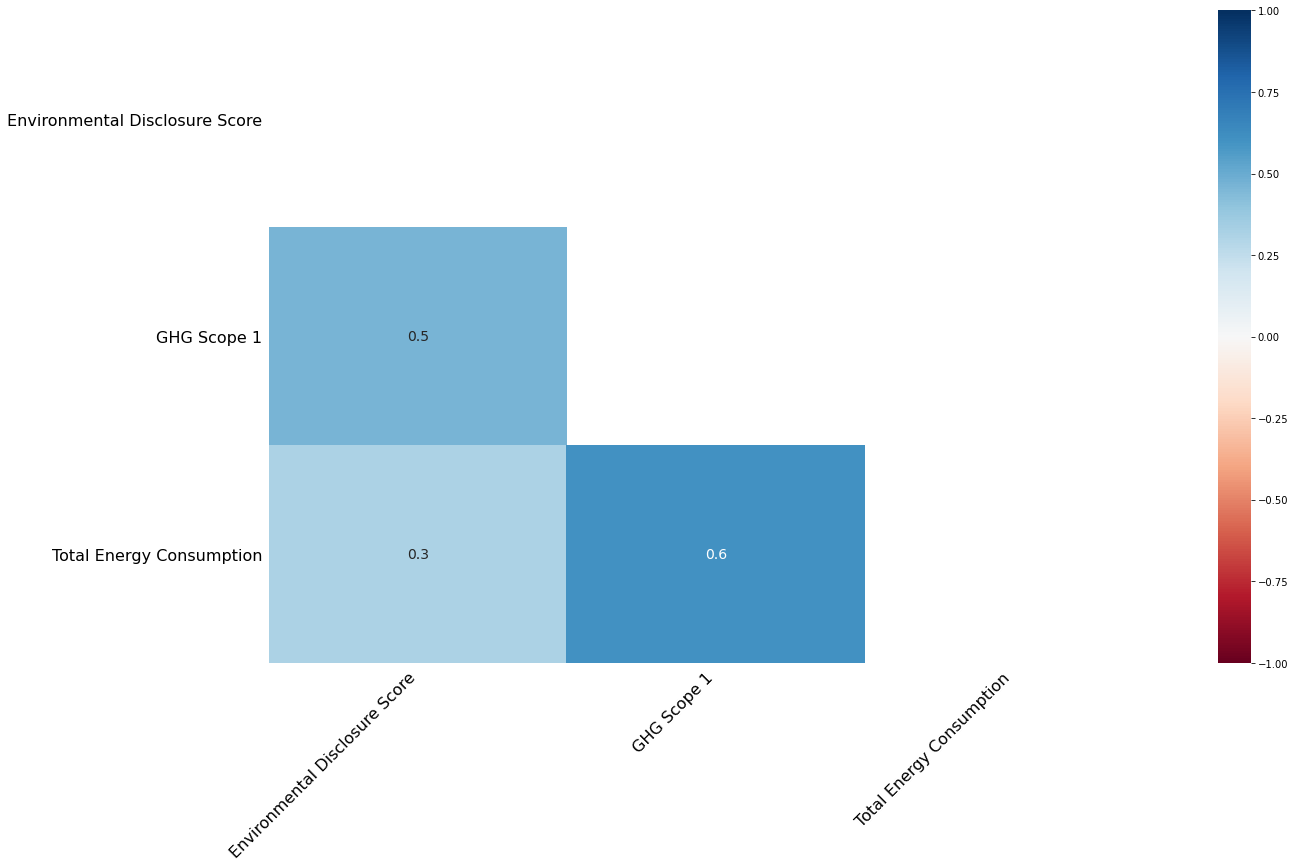

In [38]:
msno.heatmap(esg);

In [39]:
esg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            780 non-null    int64  
 1   Ticker                          780 non-null    object 
 2   Environmental Disclosure Score  636 non-null    float64
 3   GHG Scope 1                     398 non-null    float64
 4   Total Energy Consumption        243 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 30.6+ KB


As the visualization and the table presents, we are missing a huge amount of data. However, we are going to proceed to calculate growth ratios with the data available

### Growth ratios

We are going to calculate the changes in Environment Disclosure, GHG Scope, and Total Energy Consumption. As presented, the dataset contains a lot of null values, therefore, some ratios will stay as 'NaN'. Hopefully, this growths ratios will help us to get better insights. 


Formulas:

- % Change in Environmental Disclosure Score = ((Environmental Disclosure Score in Current Year) / (Environmental Disclosure Score Last Year) - 1) * 100
- % Change in GHG Scope 1 = ((GHG Scope 1 in Current Year) / (GHG Scope 1 Last Year) - 1) * 100
- % Change in Total Energy Consumption = ((Total Energy Consumption in Current Year) / (Total Energy Consumption Last Year) - 1) * 100



In [40]:
esg['Change_in_EDS'] = esg.groupby(['Ticker'])['Environmental Disclosure Score'].apply(lambda x: x.pct_change()).to_numpy() * 100
esg['Change_in_GHG'] = esg.groupby(['Ticker'])['GHG Scope 1'].apply(lambda x: x.pct_change()).to_numpy() * 100
esg['Change_in_TEC'] = esg.groupby(['Ticker'])['Total Energy Consumption'].apply(lambda x: x.pct_change()).to_numpy() * 100
esg.head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC
0,2005,AEE,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,AEE,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,AEE,9.7,NaN,NaN,NaN,NaN,NaN
3,2008,AEE,9.7,NaN,NaN,0.000000,NaN,NaN
4,2009,AEE,12.4,NaN,NaN,27.835052,NaN,NaN


## Merging the three datasets to one file

In [41]:
data = pd.merge(esg, stocks, how="left", left_on = ['Ticker','Year'], right_on = ['tic','fyear'])
data = pd.merge(data, yahoo_annual_returns, how="left", left_on = ['Ticker','Year'], right_on = ['Ticker','Year'])
cols = ["gvkey","datadate","fyear","tic","cik","cusip"]
data.drop(columns = cols, inplace=True)
print(data.shape)
data.head()

(780, 18)


,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,conm,at,ni,sale,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Annual_Stock_Return
0,2005,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,18162.0,619.0,6780.0,0.000000,0.000000,0.000000,3.408215,9.129794,NaN
1,2006,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,19578.0,558.0,6880.0,1.474926,7.796498,-9.854604,2.850138,8.110465,NaN
2,2007,AEE,9.7,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,20728.0,629.0,7546.0,9.680233,5.873940,12.724014,3.034543,8.335542,NaN
3,2008,AEE,9.7,NaN,NaN,0.000000,NaN,NaN,AMEREN CORP,22657.0,615.0,7839.0,3.882852,9.306252,-2.225755,2.714393,7.845388,NaN
4,2009,AEE,12.4,NaN,NaN,27.835052,NaN,NaN,AMEREN CORP,23790.0,612.0,7090.0,-9.554790,5.000662,-0.487805,2.572509,8.631876,NaN


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            780 non-null    int64  
 1   Ticker                          780 non-null    object 
 2   Environmental Disclosure Score  636 non-null    float64
 3   GHG Scope 1                     398 non-null    float64
 4   Total Energy Consumption        243 non-null    float64
 5   Change_in_EDS                   589 non-null    float64
 6   Change_in_GHG                   377 non-null    float64
 7   Change_in_TEC                   237 non-null    float64
 8   conm                            757 non-null    object 
 9   at                              754 non-null    float64
 10  ni                              754 non-null    float64
 11  sale                            754 non-null    float64
 12  Change_in_Sales                 754 

### Calculate ratios with Bloomberg Data and WRDS

We need to consider the company size in their emission. Therefore, we would calculate the following ratios to take into consideration the company size. 

- Ratio of GHG Emissions to Total Assets = (GHG Scope 1 * 1000) / Total Assets
- Ratio of GHG Emissions to Total Sales = (GHG Scope 1 * 1000) / Total Sales
- Ratio of Total Energy Consumption to Total Assets = (Total Energy Consumption * 1000) / Total Assets
- Ratio of Total Energy Consumption to Total Sales = (Total Energy Consumption * 1000) / Total Sales


We will calculate this ratio for each observation (each year for each company). 


In [43]:
data['Ratio of GHG Emissions to Total Assets'] = data['GHG Scope 1'] * 1000 / data['at']
data['Ratio of GHG Emissions to Total Sales'] = data['GHG Scope 1'] * 1000 / data['sale']
data['Ratio of Total Energy Consumption to Total Assets'] = data['Total Energy Consumption'] * 1000 / data['at']
data['Ratio of Total Energy Consumption to Total Sales'] = data['Total Energy Consumption'] * 1000 / data['sale']
data.head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,conm,at,...,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Annual_Stock_Return,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales
0,2005,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,18162.0,...,0.000000,0.000000,0.000000,3.408215,9.129794,NaN,NaN,NaN,NaN,NaN
1,2006,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,19578.0,...,1.474926,7.796498,-9.854604,2.850138,8.110465,NaN,NaN,NaN,NaN,NaN
2,2007,AEE,9.7,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,20728.0,...,9.680233,5.873940,12.724014,3.034543,8.335542,NaN,NaN,NaN,NaN,NaN
3,2008,AEE,9.7,NaN,NaN,0.000000,NaN,NaN,AMEREN CORP,22657.0,...,3.882852,9.306252,-2.225755,2.714393,7.845388,NaN,NaN,NaN,NaN,NaN
4,2009,AEE,12.4,NaN,NaN,27.835052,NaN,NaN,AMEREN CORP,23790.0,...,-9.554790,5.000662,-0.487805,2.572509,8.631876,NaN,NaN,NaN,NaN,NaN


Now, we are going to create three more columns:

1) Profitable - Indicates if the company was profitable that year 
2) Natural logarithm for total assets
3) Natural logarithm for total sales 


Also, we will rename some columns for visualization purposes. 

In [44]:
data['Profitable'] = np.where(data.ni > 0, True, False)
data['Logarithm_Total_Assets'] = np.log(data['at'])
data['Logarithm_Total_Sales'] = np.log(data['sale'])
rename = {'at': "Total_Assets", 'ni': "Net_Income", 'sale': "Total_Sales","conm": "Company"}
data.rename(columns=rename, inplace=True)
data.head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Change_in_TEC,Company,Total_Assets,...,ROA,Profit_Margin,Annual_Stock_Return,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Logarithm_Total_Assets,Logarithm_Total_Sales
0,2005,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,18162.0,...,3.408215,9.129794,NaN,NaN,NaN,NaN,NaN,True,9.807087,8.821732
1,2006,AEE,NaN,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,19578.0,...,2.850138,8.110465,NaN,NaN,NaN,NaN,NaN,True,9.882162,8.836374
2,2007,AEE,9.7,NaN,NaN,NaN,NaN,NaN,AMEREN CORP,20728.0,...,3.034543,8.335542,NaN,NaN,NaN,NaN,NaN,True,9.939241,8.928773
3,2008,AEE,9.7,NaN,NaN,0.000000,NaN,NaN,AMEREN CORP,22657.0,...,2.714393,7.845388,NaN,NaN,NaN,NaN,NaN,True,10.028224,8.966867
4,2009,AEE,12.4,NaN,NaN,27.835052,NaN,NaN,AMEREN CORP,23790.0,...,2.572509,8.631876,NaN,NaN,NaN,NaN,NaN,True,10.077021,8.866441


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 25 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               780 non-null    int64  
 1   Ticker                                             780 non-null    object 
 2   Environmental Disclosure Score                     636 non-null    float64
 3   GHG Scope 1                                        398 non-null    float64
 4   Total Energy Consumption                           243 non-null    float64
 5   Change_in_EDS                                      589 non-null    float64
 6   Change_in_GHG                                      377 non-null    float64
 7   Change_in_TEC                                      237 non-null    float64
 8   Company                                            757 non-null    object 
 9   Total_Asse

In [46]:
data.loc[(data.Ticker == 'BKR') & (data.Company.isna()), 'Company'] = 'BAKER HUGHES CO'
data.loc[(data.Ticker == 'FANG') & (data.Company.isna()), 'Company'] = 'DIAMONDBACK ENERGY INC'
data.loc[(data.Ticker == 'MPC') & (data.Company.isna()), 'Company'] = 'MARATHON PETROLEUM CORP'
data.loc[(data.Ticker == 'PSX') & (data.Company.isna()), 'Company'] = 'PHILLIPS 66'

In [47]:
#data.to_csv('pilot_stocks.csv', index=False)

Now, we are going to continue our analysis in the 'Exploratory Data Analysis-Pilot Stocks' notebook. 